In [ ]:
# import pandas as pd
import matplotlib.pyplot as plt
import mpld3
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from math import sin, cos, sqrt, atan2, radians
from ipywidgets import Checkbox, HBox, VBox, Layout, Button, FloatSlider, FloatText, IntText
from IPython.display import Javascript, display
from functools import partial

# approximate radius of earth in km
R = 6373.0
# Should use this for measuring distances if possible
def lldist(lat1, lon1, lat2, lon2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

%matplotlib inline
df = pd.read_excel("Grilla para Urbest 2020-08-26.xlsx",sheet_name=0).dropna()
#df_2 = pd.read_excel("Grilla para Urbest 2020-08-26 ANEXO.xlsx",sheet_name=0).dropna()
#df = pd.concat([df,df_2])
desc = pd.read_excel("Grilla para Urbest 2020-08-26.xlsx",sheet_name=1).dropna(subset=['Variable a 800 metros'])
#print(df.head)

### Selectores de variables

In [23]:
desc_main =  {var: desc.loc[desc['Variable a 800 metros'] == var, 'Definición'].values[0] for var in desc['Variable a 800 metros'].to_list()[:1]}
desc_main.update({'latitude':'Latitud','longitude':'Longitud'})
desc_800 = {var: desc.loc[desc['Variable a 800 metros'] == var, 'Definición'].values[0] + ' (800 metros)' for var in desc['Variable a 800 metros'].to_list()[1:]}
desc_1600 = {var: desc.loc[desc['Variable a 1600 metros'] == var, 'Definición'].values[0] + ' (1600 metros)' for var in desc['Variable a 1600 metros'].to_list()[1:]}
desc_all = {} 
desc_all.update(desc_main)
desc_all.update(desc_800)
desc_all.update(desc_1600)
bools_all = {i: False if '(1600 metros)' in desc_all[i] else True for i in desc_all} #condicion para 1600 deshabilitado por default
bools_all['latitude'] = False
bools_all['longitude'] = False
#print(desc_all)

In [24]:
ev_count = 0
def tick(ch,key):
    global ev_count    #Evitar repeats
    ev_count += 1
    if ev_count > 2:
        val = ch.owner.value
        bools_all[key] = val
        #print(bools_all)
        ev_count = 0
    return 
chboxes = [Checkbox(bools_all[i],description=i +':'+desc_all[i]) for i in desc_all.keys()] #agregar nombre de la variable a la descripcion...
ch_per_wcol = int(len(chboxes)/3)
wcol_1 = VBox(chboxes[:ch_per_wcol])
wcol_2 = VBox(chboxes[ch_per_wcol:ch_per_wcol*2])
wcol_3 = VBox(chboxes[ch_per_wcol*2:])
hb = HBox([wcol_1,wcol_2,wcol_3])
for ch in chboxes:
    k = ch.description.split(':')[0]
    ch.description = ch.description.split(':')[1] #...y remover variable de la descripcion despues de ser obtenida
    ch.observe(partial(tick,key=k))
display(hb)

In [25]:
def crear_modelo(btn):
    display(Javascript('IPython.notebook.execute_cells_below()'))
#TODO: Encapsulate methods in functions so it doesn't execute all cells. Though it may still need to
btn = Button(description="Make model")
btn.on_click(crear_modelo)
display(btn)

Button(description='Make model', style=ButtonStyle())

In [26]:
#Not part of the variables set: 'id','name','project','status','city',
data_cols = [i for i in bools_all if bools_all[i] == True]
#print(data_cols)

## Diagramas UMAP

<AxesSubplot:xlabel='umap_0', ylabel='umap_1'>

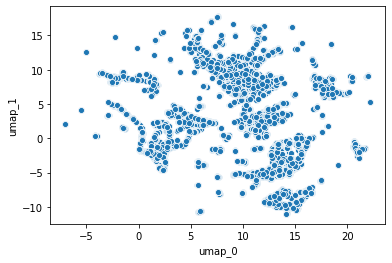

In [27]:
raw_data = df[data_cols].values
std_data = StandardScaler().fit_transform(raw_data)
red = umap.UMAP(n_neighbors=10,random_state=55).fit(std_data) #Fixed RNG seed
ids = df["id"]
embedding = red.embedding_ #Was red.fit_transform
embedding_df = pd.DataFrame(data=embedding, index=ids.values, columns=["umap_0", "umap_1"])
sns.scatterplot(x=embedding_df["umap_0"], y=embedding_df["umap_1"])

In [28]:
x_min = min(df["latitude"])
y_min = min(df["longitude"])
d_x = df.set_index("id")["latitude"].apply(lambda x: x - x_min)
d_y = df.set_index("id")["longitude"].apply(lambda y: y - y_min)
d_x = d_x / max(d_x)
d_y = d_y / max(d_y)
emb_df = embedding_df.copy()
emb_df["d_x"] = d_x
emb_df["d_y"] = d_y

<AxesSubplot:xlabel='umap_0', ylabel='umap_1'>

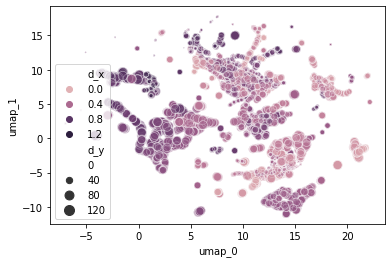

In [29]:
cmap = sns.cubehelix_palette(light=0.75,as_cmap=True)
sns.scatterplot(x=emb_df["umap_0"], y=emb_df["umap_1"], alpha = 0.5, size=100 * emb_df["d_y"], sizes=(0, 100), hue = emb_df["d_x"], palette=cmap)

## Mapa de marcadores

<AxesSubplot:xlabel='d_y', ylabel='d_x'>

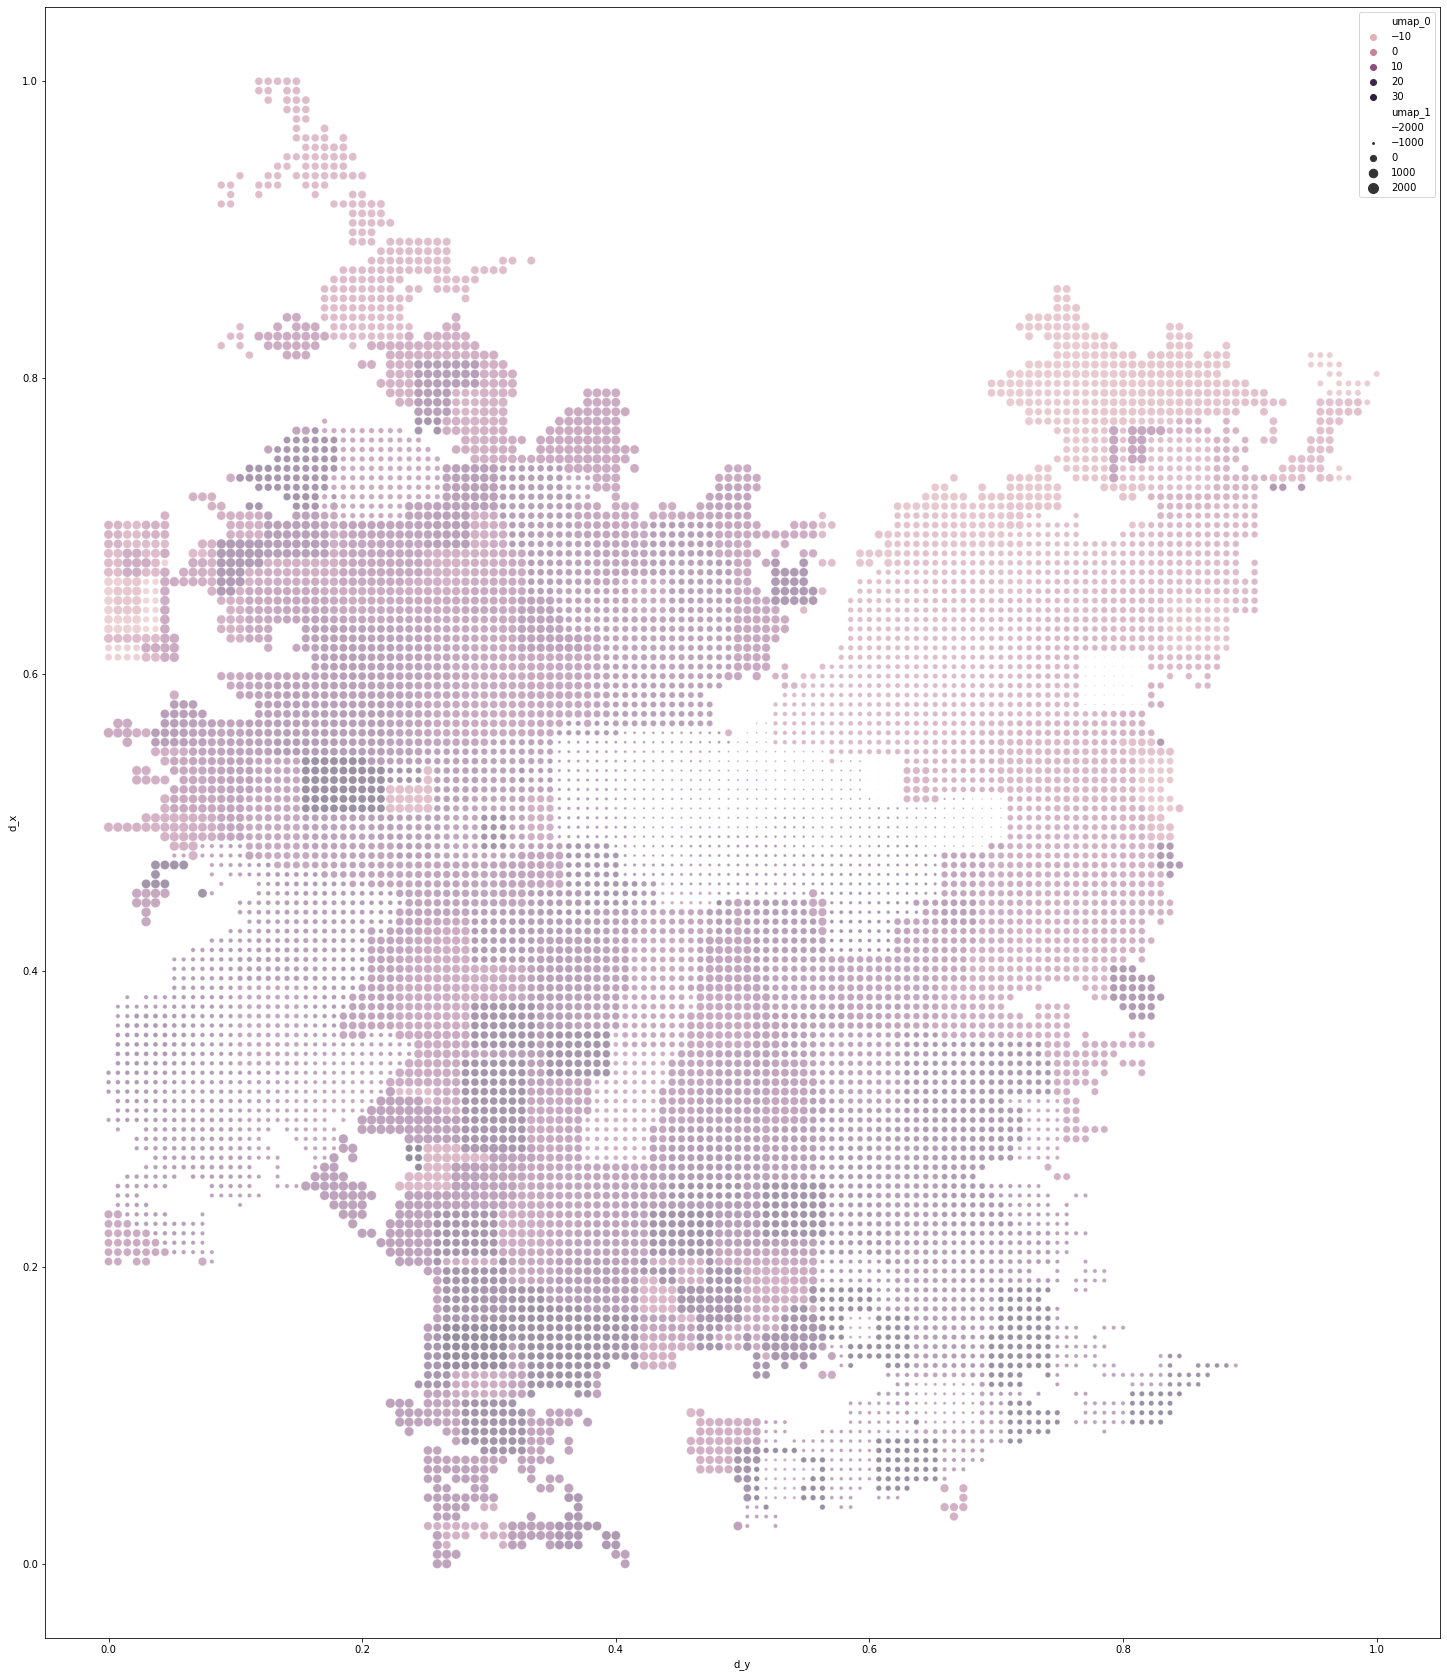

In [30]:
plt.figure(figsize=(25,30))
#plt.axis('equal')
sns.scatterplot(x=emb_df["d_y"], y=emb_df["d_x"], alpha = 0.5, size=100 * emb_df["umap_1"], sizes=(0, 100), hue = emb_df["umap_0"], palette=cmap)

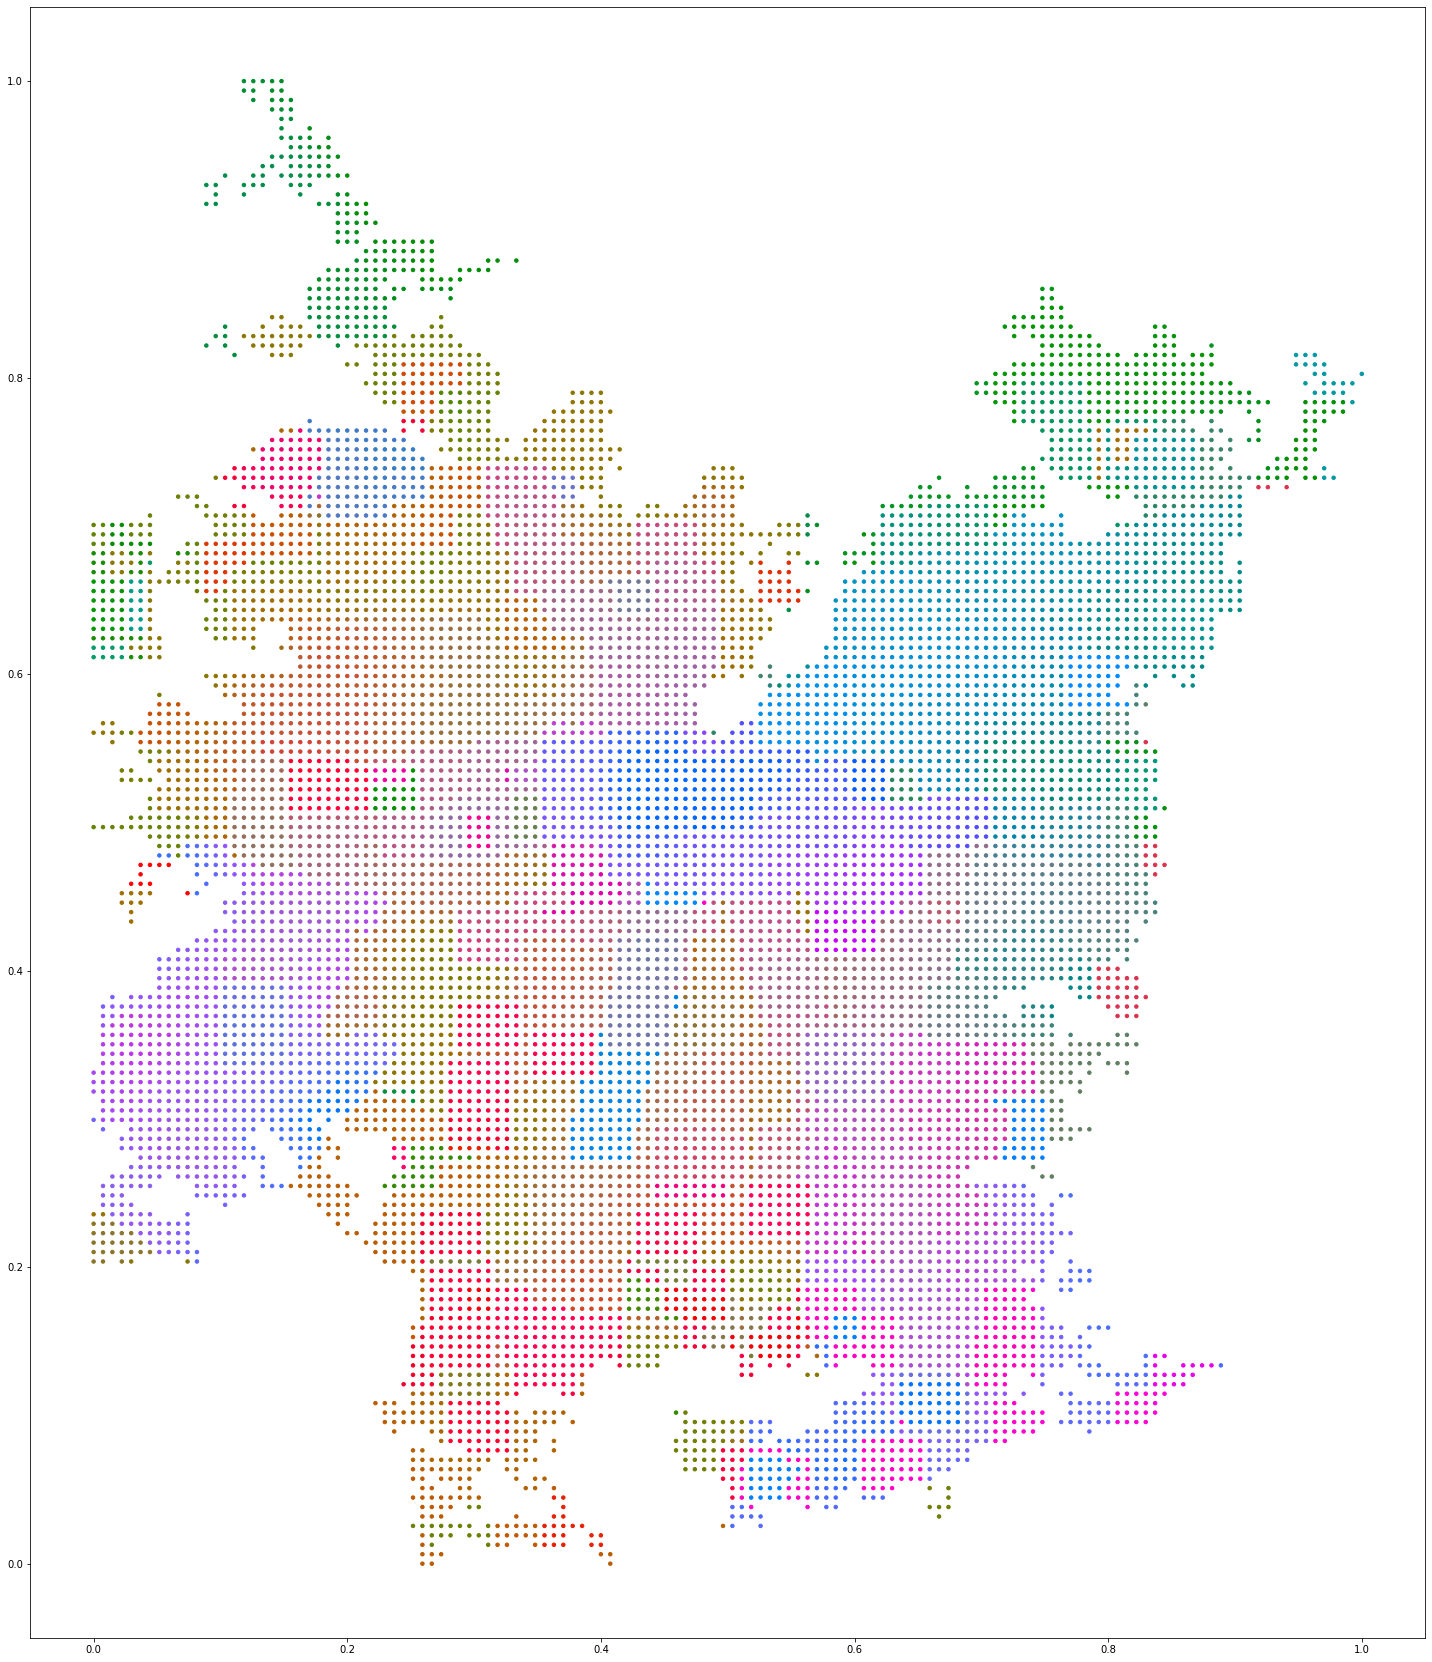

In [31]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from sklearn.preprocessing import MinMaxScaler
#Ranges: 0,1 for RGB, -128,127 for CIELAB
lab_light = 50 #CIELAB L variable
emb_df[['umap_norm_0','umap_norm_1']] = MinMaxScaler(feature_range=(-127,128)).fit_transform(emb_df[['umap_0','umap_1']])
emb_df['umap_color_lab'] = emb_df.apply(lambda x: LabColor(lab_light,x['umap_norm_0'], x['umap_norm_1']), axis=1)
emb_df['umap_color_rgb'] = emb_df.apply(lambda x: convert_color(x['umap_color_lab'], sRGBColor), axis=1) #para poder ser ploteado, hay que convertir a RGB
emb_df['umap_color_rgb'] = emb_df.apply(lambda x: (x['umap_color_rgb'].clamped_rgb_r,x['umap_color_rgb'].clamped_rgb_g,x['umap_color_rgb'].clamped_rgb_b), axis=1) #Se pierde fidelidad al clampear
#ax = plt.gca()
#print(ax.get_position())
plt.figure(figsize=(25,30))
plt.scatter(emb_df['d_y'],emb_df['d_x'],c = emb_df['umap_color_rgb'],s=12)

In [32]:
mark_id = 266218 #ID of the reference marker. Currently a known marker that exists in the dataset as default
threshold = 0.14 #Maximum UMAP distance to graph
min_dist = 0 #Minimum geographical distance to graph in the PCA stage

def make_comparisons(btn):
    global mark_id
    mark_id = id_field.value
    display(Javascript('IPython.notebook.execute_cells_below()'))
    
def id_observer(field):
    global mark_id
    mark_id = field.new
    
comp_btn = Button(description="Make comparisons")
comp_btn.on_click(make_comparisons)
id_field = IntText(value=266218, description='Marker ID')
display(comp_btn, id_field)

Button(description='Make comparisons', style=ButtonStyle())

IntText(value=266218, description='Marker ID')

In [33]:
def umap_dist(x_u0,x_u1,y_u0,y_u1):
    return sqrt((x_u0 -  y_u0)**2 + (x_u1 - y_u1)**2)
    
def max_dist(umap_pts): #Input: [(umap_x_1, umap_y_1),...]
    max_dist = 0
    for (x, y) in umap_pts:
        for (w, z) in umap_pts:
            d = umap_dist(x,y,w,z)
            if d > max_dist:
                max_dist = d
    return max_dist

#mark_colr = emb_df.loc[mark_id,'umap_color_lab']
#emb_df['color_sim'] = emb_df.apply(lambda x: delta_e_cie2000(mark_colr,x['umap_color_lab']), axis=1) #Lento, evitese ejecutar demasiado
mark_u0 = emb_df.loc[mark_id,'umap_0']
mark_u1 = emb_df.loc[mark_id,'umap_1']
maximum = max_dist([(u0,u1) for u0,u1 in zip(emb_df['umap_0'],emb_df['umap_1'])])    #Lento
emb_df['mark_umap_dist'] = emb_df.apply(lambda x: umap_dist(mark_u0,mark_u1,x['umap_0'],x['umap_1'])/maximum, axis=1) #Normalizado

In [34]:
def threshold_observer(field):
    global threshold
    threshold = field.new
    display(Javascript('IPython.notebook.execute_cells_below()'))

threshold_field = FloatText(value=threshold,Min=0,Max=20,description='Nivel de diferencia')
threshold_field.observe(threshold_observer,'value')
display(threshold_field)

FloatText(value=0.14, description='Nivel de diferencia')

In [35]:
def relative_change(x,y):
    return abs(x-y)/((abs(x)+abs(y))/2)

#emb_df_sim = emb_df.loc[emb_df['color_sim']<=threshold].copy()
emb_df_sim = emb_df.loc[emb_df['mark_umap_dist']<=threshold].copy()
emb_df_sim['mark_umap_rc'] = emb_df_sim.apply(lambda x: (relative_change(mark_u0,x['umap_0'])+relative_change(mark_u1,x['umap_1']))/2, axis=1) #Percentage of similarity against marked id
df_geo = df[['id','latitude','longitude']].set_index('id')
emb_df_sim = emb_df_sim.join(df_geo,how='inner')
mark = df.loc[df['id']==mark_id]
mark_geo = (df.loc[df['id']==mark_id]['latitude'],df.loc[df['id']==mark_id]['longitude'])
emb_df_sim['mark_geo_dist'] = emb_df_sim.apply(lambda x: lldist(mark_geo[0],mark_geo[1],x['latitude'],x['longitude']), axis=1)
emb_df_sim.to_csv('geodata.csv')

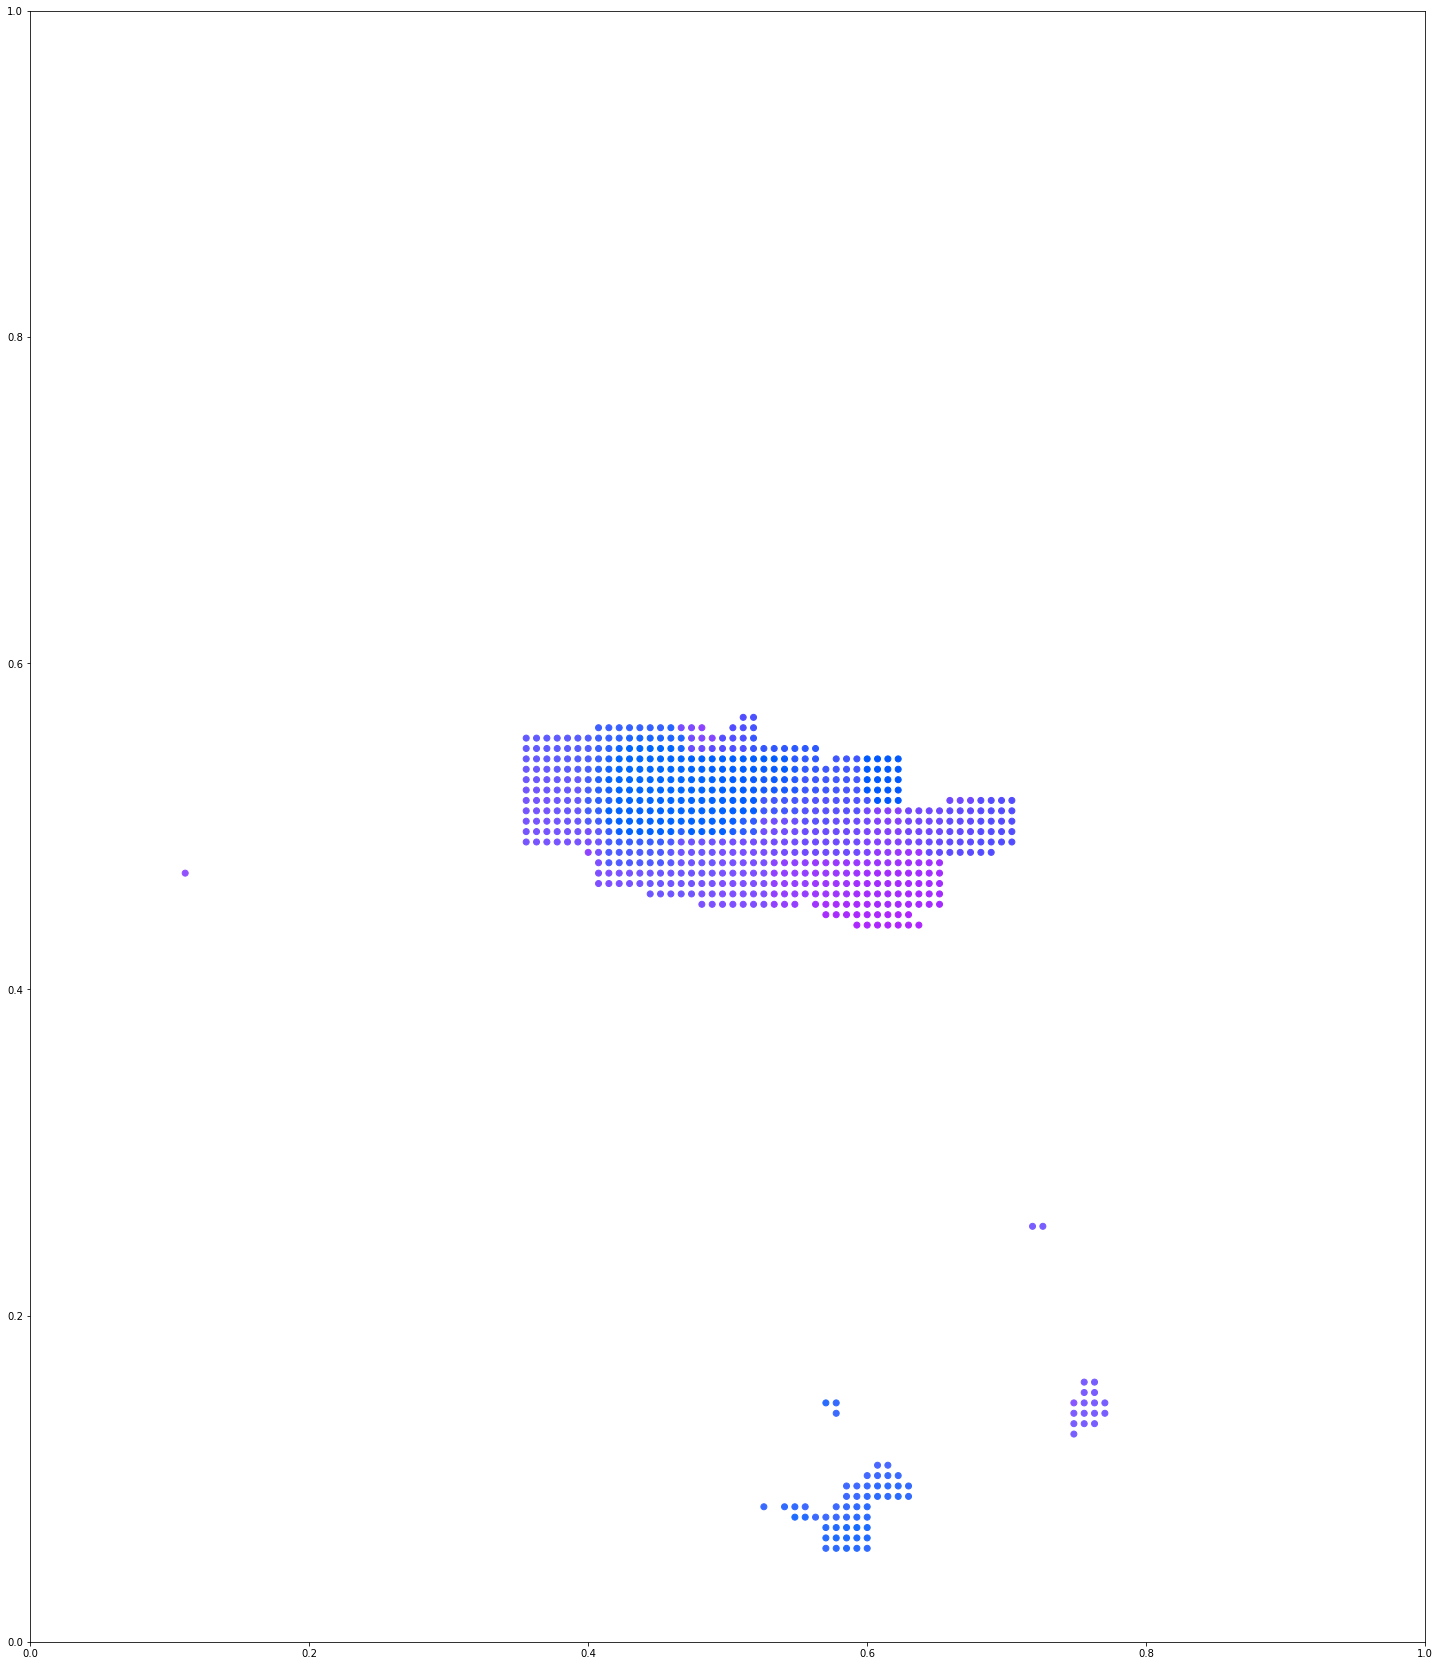

Average relative change (percentage): 11.389292906193994%


In [36]:
plt.figure(figsize=(25,30))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(emb_df_sim['d_y'],emb_df_sim['d_x'],c = emb_df_sim['umap_color_rgb'])
plt.show()
rc_pro = emb_df_sim.drop([mark_id])['mark_umap_rc'].mean()*100
print('Average relative change (percentage): ' + str(rc_pro) + '%')

In [41]:
fig, ax = plt.subplots(figsize=(13,13))
fig.tight_layout()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
scatter = ax.scatter(emb_df_sim['d_y'],emb_df_sim['d_x'],c = emb_df_sim['umap_color_rgb'])
ax.scatter(emb_df_sim.loc[mark_id]['d_y'],emb_df_sim.loc[mark_id]['d_x'],c='k',marker='*')
html_label = '<label>ID {0}<br> Geographical Distance {1}<br> UMAP Distance {2}<br> Relative Change {3}%</label>'
labels = [html_label.format(id,geo_d,umap_d,rc*100) for id,geo_d,umap_d,rc in zip(emb_df_sim.index,emb_df_sim['mark_geo_dist'],emb_df_sim['mark_umap_dist'],emb_df_sim['mark_umap_rc'])]
tooltip = mpld3.plugins.PointHTMLTooltip(scatter, labels=labels,css="label{ background-color:#aaaaaa;opacity: 0.75;}")
mpld3.plugins.connect(fig, tooltip)
mpld3.display()

In [38]:
from sklearn.decomposition import PCA
filter_ids = emb_df_sim.index
df_pca = df[df['id'].isin(filter_ids)].copy().reset_index()
raw_data_pca = df_pca[data_cols].values
std_data_pca = StandardScaler().fit_transform(raw_data_pca)
pca = PCA(n_components=2)
pc_data = pca.fit_transform(std_data_pca)
pc_df = pd.DataFrame(data = pc_data,columns = ['pc_0', 'pc_1'])
sim_data = emb_df_sim[['umap_color_rgb','mark_geo_dist']].reset_index().rename(columns={"index": "id"}) #Restoring the id column from index
pc_df = pd.concat([pc_df, sim_data], axis = 1)

In [39]:
def min_dist_observer(field):
    global min_dist
    min_dist = field.new
    display(Javascript('IPython.notebook.execute_cells_below()'))

min_dist_field = FloatText(value=min_dist,Min=0,Max=20,description='Minimum geographical distance')
min_dist_field.observe(min_dist_observer,'value')
display(min_dist_field)

FloatText(value=0.0, description='Minimum geographical distance')

In [42]:
pc_df_filtered = pc_df.loc[pc_df['mark_geo_dist']>=min_dist].copy()
fig, ax = plt.subplots(figsize=(10,10))
fig.tight_layout()
#ax.set_xlim([-6,14])
#ax.set_ylim([-6,14])
ax.set_aspect('equal', adjustable='datalim')
scatter = ax.scatter(pc_df_filtered['pc_0'],pc_df_filtered['pc_1'],c = pc_df_filtered['umap_color_rgb'])
ax.scatter(pc_df[pc_df['id']==mark_id]['pc_0'],pc_df[pc_df['id']==mark_id]['pc_1'],c='k',marker='*')
labels = ['<label>ID: {0}<br>Distancia geográfica: {1}</label>'.format(id,geo_dist) for id,geo_dist in zip(pc_df_filtered['id'],pc_df_filtered['mark_geo_dist'])]
tooltip = mpld3.plugins.PointHTMLTooltip(scatter, labels=labels,css="label{ background-color:#aaaaaa;opacity: 0.75;}")
mpld3.plugins.connect(fig, tooltip)
mpld3.display()

d:\prog\python38\lib\site-packages\mpld3\mplexporter\exporter.py:267: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
